In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn import preprocessing
import category_encoders as ce

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\comaz\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# hotel_address — адрес отеля;
# review_date — дата, когда рецензент разместил соответствующий отзыв;
# average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
# hotel_name — название отеля;
# reviewer_nationality — страна рецензента;
# negative_review — отрицательный отзыв, который рецензент дал отелю;
# review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
# positive_review — положительный отзыв, который рецензент дал отелю;
# review_total_positive_word_counts — общее количество слов в положительном отзыве.
# reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
# total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
# total_number_of_reviews — общее количество действительных отзывов об отеле;
# tags — теги, которые рецензент дал отелю;
# days_since_review — количество дней между датой проверки и датой очистки;
# additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. 
#       Это число указывает, сколько там действительных оценок без проверки.
# lat — географическая широта отеля;
# lng — географическая долгота отеля.

In [3]:
df = pd.read_csv('data/hotels.csv')
df.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Проектирование признаков

In [5]:
def generate_new_data(df: pd.DataFrame):
    """Функция для предобрпботки данных для определенного датафрейма.
    
    Args:
        df (pd.DataFrame): набор данных
    Returns:
        df (pd.DataFrame): обработанный набор данных
    """
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['month'] = df.review_date.dt.month_name()
    df['splited_tags'] = df['tags'].str.findall(r"'[\w\s]+'")
    df['splited_tags'] = df['splited_tags'].apply(lambda x: [y[1:-1].strip().replace(' ', '_').lower() for y in x])
    df['hotel_country'] = df['hotel_address'].apply(lambda x: ' '.join(x.split()[-2:]) if x.find('Kingdom') != -1 else x.split()[-1])
    df['hotel_city'] = df['hotel_address'].apply(lambda x: ' '.join(x.split()[-5:-4]) if x.find('Kingdom') != -1 else x.split()[-2])
    df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x.split()[0]))
    
    return df

In [6]:
#работа с тегами 
def get_tags(df, nunique=10):
    """
    Функция для получения популярных тэгов из данных.
    Считает тэги во всём наборе данных и создаёт индикаторы столбцы самых популярных из них

    Args:
        df (pd.DataFrame): набор данных
        nunique (int): кол-во самых популярных тэгов

    Returns:
        df (pd.DataFrame): обработанный набор данных
    """
    from  collections import Counter
    tags = Counter()
    for lst in df['splited_tags']:
        for tag in lst:
            tags[tag] += 1
        
    lst_tags = sorted(tags, key=lambda x: tags[x], reverse=True)[:nunique]
    for tag in lst_tags:
        df[tag] = 0

        df[tag] = df['splited_tags'].apply(lambda x: 1 if tag in x else 0)
    return df

In [7]:
df = generate_new_data(df)
df = get_tags(df)

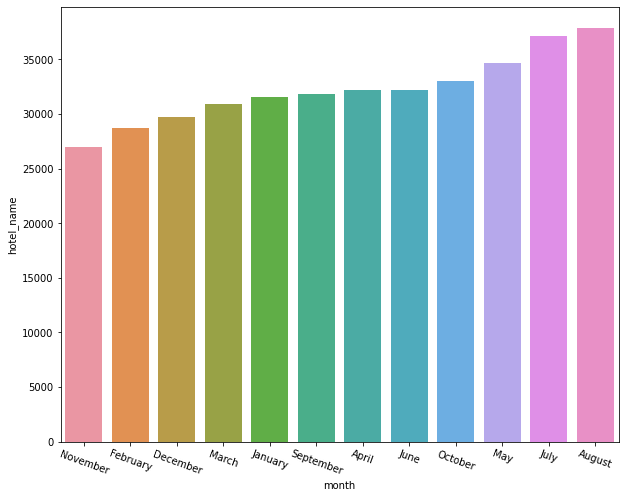

In [8]:
plt.figure(figsize=(10,8))
sns.barplot(df.groupby('month')['hotel_name'].count().reset_index().sort_values(by='hotel_name'), x='month', y='hotel_name')
plt.xticks(rotation=-20);
# чаще всего рецензенты посещают отель перед началом учебного года

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [10]:
# заполним пропущенные значения модой по городам
for city in df['hotel_city'].unique():
    mask = df['hotel_city'] == city
    df.loc[mask, 'lat'] = df[mask]['lat'].fillna(df[mask]['lat'].mode()[0])
    df.loc[mask, 'lng'] = df[mask]['lng'].fillna(df[mask]['lng'].mode()[0])

In [11]:

pos_review = 'review_total_positive_word_counts'
neg_review = 'review_total_negative_word_counts'
df['total_word_review_count'] = df[pos_review] + df[neg_review] + 1
df['proportion_word_review'] = df[pos_review] / df['total_word_review_count']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [248]:
# importing geopy library
# from geopy.geocoders import Nominatim
# from geopy.distance import geodesic as gd

# # calling the Nominatim tool
# loc = Nominatim(user_agent="GetLoc",)

# # entering the location name
# getLoc = loc.geocode("London")
# cent = (getLoc.latitude, getLoc.longitude)
# # printing address
# print(getLoc.address)

# # printing latitude and longitude
# print("Latitude = ", getLoc.latitude, "\n")
# print("Longitude = ", getLoc.longitude)


# print(f"расстояние до центра {gd(cent, (51.507894, -0.143671))}")

London, Greater London, England, United Kingdom
Latitude =  51.5073359 

Longitude =  -0.12765
расстояние до центра 1.114052867447938 km


In [249]:
# city_centr = {}
# for city in df['hotel_city'].unique():
#     getLoc = loc.geocode(city)
#     cent = (getLoc.latitude, getLoc.longitude)
#     city_centr[city] = cent
# city_centr

{'London': (51.5073359, -0.12765),
 'Paris': (48.8534951, 2.3483915),
 'Amsterdam': (52.3730796, 4.8924534),
 'Milan': (45.4641943, 9.1896346),
 'Vienna': (48.2083537, 16.3725042),
 'Barcelona': (41.3828939, 2.1774322)}

Работа с отзывами

In [12]:
# обрезаем пробелы по бокам и приводим все слова к нижнему регистру
df['negative_review'] = df['negative_review'].apply(lambda x: x.strip().lower())
df['positive_review'] = df['positive_review'].apply(lambda x: x.strip().lower())
# замена слов в отзыве для дальнейшей обработки отзывов
df['positive_review'] = df['positive_review'].apply(lambda x: 'neutral' if x == 'no negative' or x == 'no positive' or 'nothing' in x else x)
df['negative_review'] = df['negative_review'].apply(lambda x: 'neutral' if x == 'no negative' or x == 'no positive' or 'nothing' in x else x)
df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x.strip())

In [13]:
# данный класс помогает определить, яляется ли отзыв положительным отрицательным или нейтральным

sid_obj = SentimentIntensityAnalyzer()
df['general_feedback'] = df['positive_review'] + df['negative_review']
df['general_estimation_proportion'] = df['general_feedback'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])

df['positive_estimation_proportion'] = df['positive_review'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
df['negative_estimation_proportion'] = df['negative_review'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])

# df['sentiments'] = df['review'].apply(lambda x: sid_obj.polarity_scores(x))

Кодирование признакоов

In [43]:
# ord_encoder = ce.OrdinalEncoder()
# data_bin = ord_encoder.fit_transform(df['hotel_country'])
# data_bin.rename(columns={'hotel_country':'hotel_country_ord'}, inplace=True)
# df = pd.concat([df, data_bin], axis=1)

In [44]:
# data_bin = ord_encoder.fit_transform(df['reviewer_nationality'])
# data_bin.rename(columns={'reviewer_nationality':'reviewer_nationality_ord'}, inplace=True)
# df = pd.concat([df, data_bin], axis=1)

In [128]:
# bin_encoder = ce.BinaryEncoder(['reviewer_nationality'])
# df_bin = bin_encoder.fit_transform(df[['reviewer_nationality']])
# df = pd.concat([df, df_bin], axis=1)

In [14]:
onehot_encoder = ce.OneHotEncoder(cols=['hotel_country', 'month'])
df_onehot = onehot_encoder.fit_transform(df[['hotel_country','month']])
df = pd.concat([df, df_onehot], axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

Отбор признаков

In [16]:
def get_multicorr(df, feature, corr_rate=0.7):
    """
    Функция находит сильнокоррелирующие между собой признаки и возвращает список с признаками с минимальной корреляцией с целевым признаком.

    Args:
        df (pd.DataFrame): Набор данных
        feature (_type_): Целевой признак
        corr_rate (float, optional): Минимальное значение корреляции по которому будут отбираться признаки. По умолчанию 0.7.

    Returns:
        set: список признаков которые нужно удалить из набора данных
    """
    test = df.drop(feature, axis=1).corr() 
    columns = df.drop(feature, axis=1).corr().columns
    index = df.drop(feature, axis=1).corr().index
    lst = set()
    for column in columns:
        for idx in index:
            if column != idx and abs(test.loc[idx, column]) >= corr_rate:
                if abs(df.corr()[feature][column]) > abs(df.corr()[feature][idx]):
                    lst.add(idx)
                else:
                    lst.add(column)
    return lst

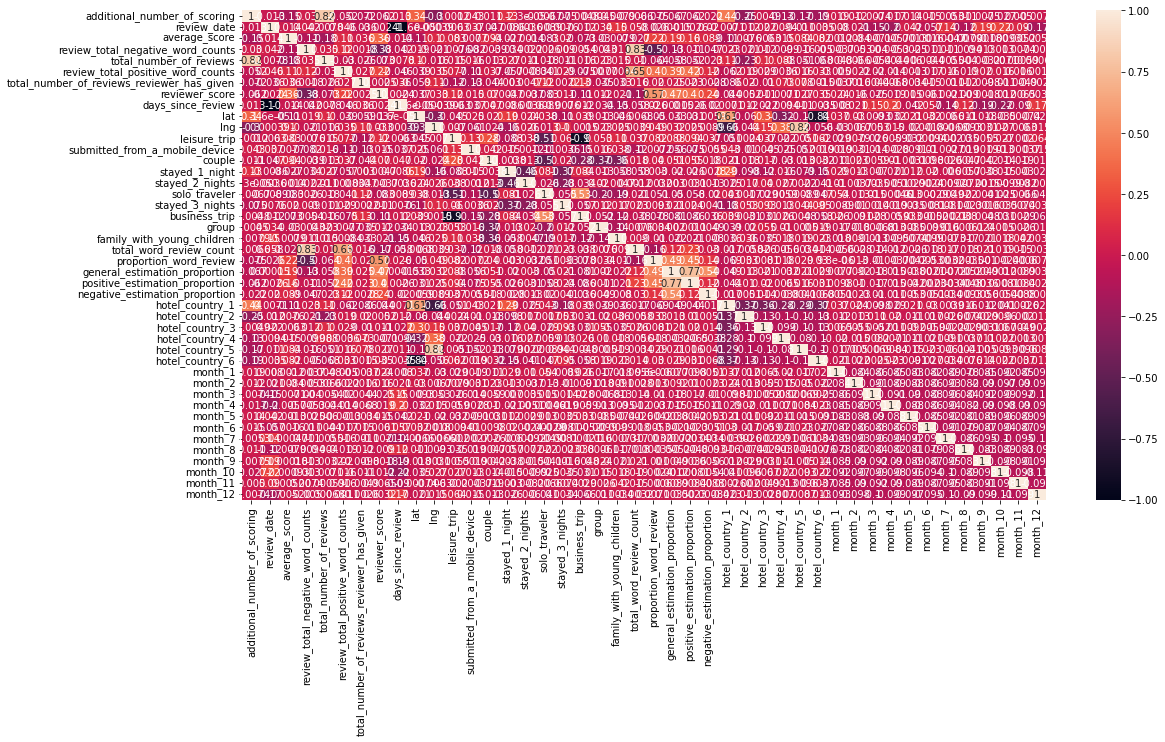

In [18]:
fig = plt.figure(figsize=(18, 9))
heatmap = sns.heatmap(df[df.describe().columns].corr(), annot=True)

In [21]:
t = df[df.describe().columns].copy()

In [23]:
# удаляем сильнокорелирующие признаки

t.drop(get_multicorr(t, 'reviewer_score'), axis=1, inplace=True)

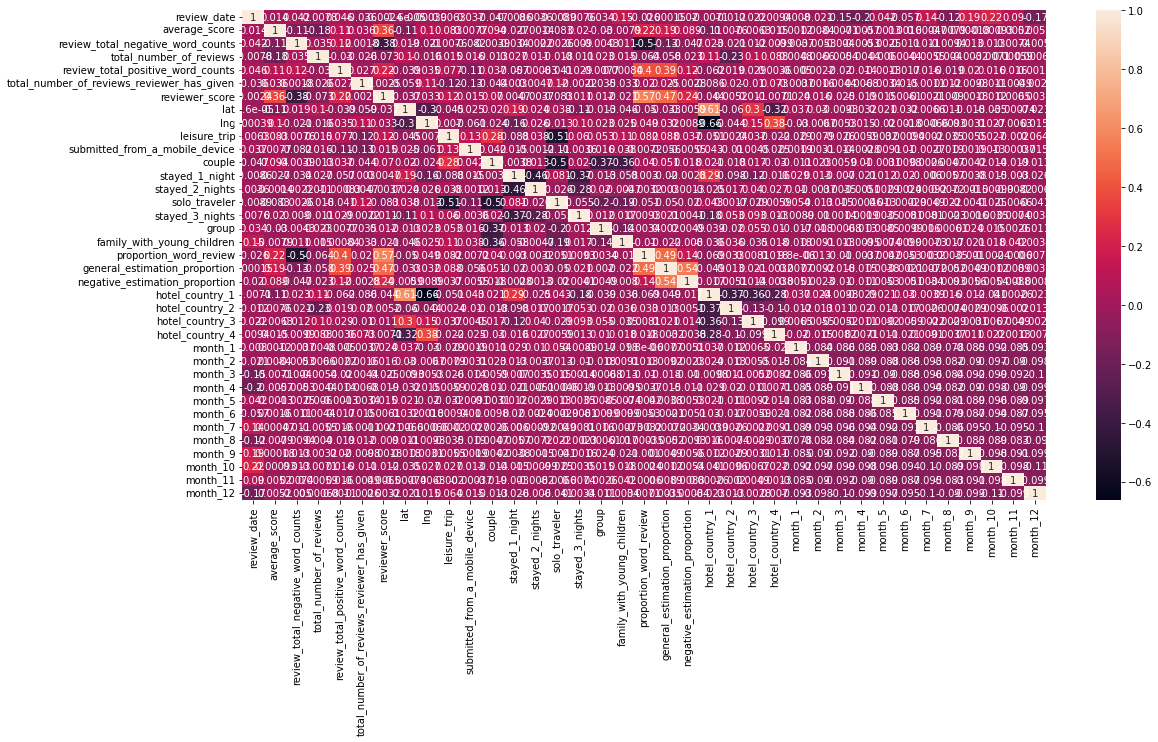

In [24]:
fig = plt.figure(figsize=(18, 9))
heatmap = sns.heatmap(t.corr(), annot=True)

In [ ]:
# features_less = list(t.corr().index[(t.corr().reviewer_score.abs() < 0.05)])
# t.drop(features_less, axis=1, inplace=True)

['total_number_of_reviews',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'count_nights',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7',
 'hotel_country_1',
 'hotel_country_2',
 'hotel_country_3',
 'hotel_country_4']

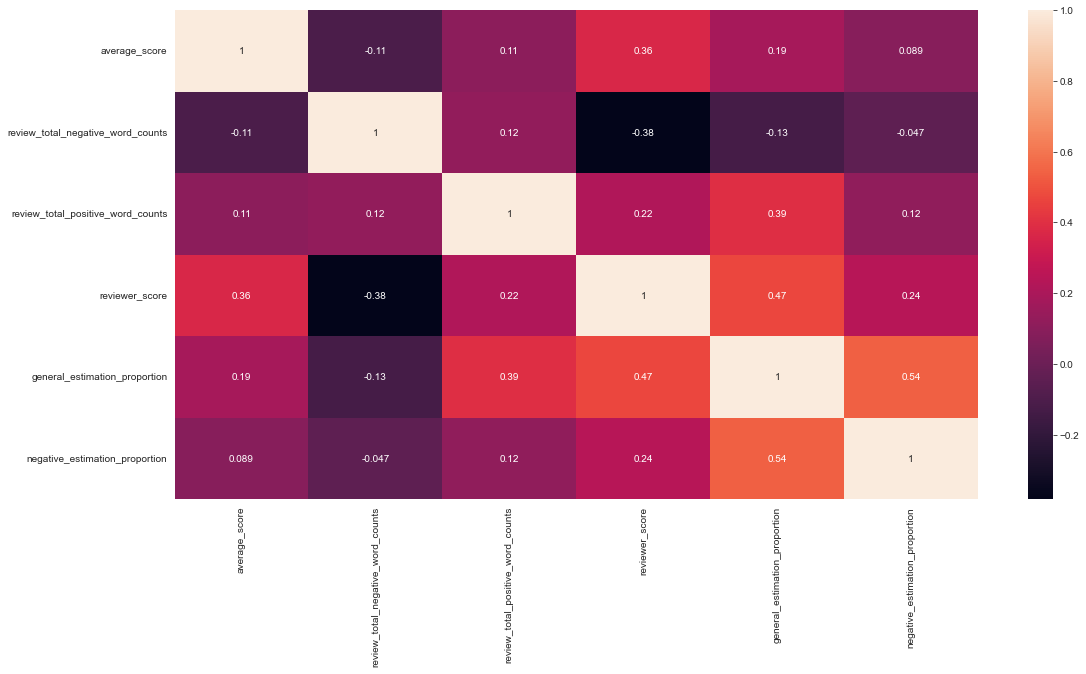

In [ ]:
# fig = plt.figure(figsize=(18, 9))
# heatmap = sns.heatmap(t.corr(), annot=True)

Подготовка к тестированию

In [29]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = t[t.describe().columns].drop(['reviewer_score','review_date'], axis = 1)  
y = t['reviewer_score'] 


In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [32]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [33]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_scaler, X_test_scaler, y_train_scaler, y_test_scaler = train_test_split(X_scaler, y, test_size=0.25, random_state=42)

In [34]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, n_jobs=-1)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [35]:
regr_scaler = RandomForestRegressor(n_estimators=100, n_jobs=-1)  
      
# Обучаем модель на тестовом наборе данных  
regr_scaler.fit(X_train_scaler, y_train_scaler)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred_scaler = regr_scaler.predict(X_test_scaler)  


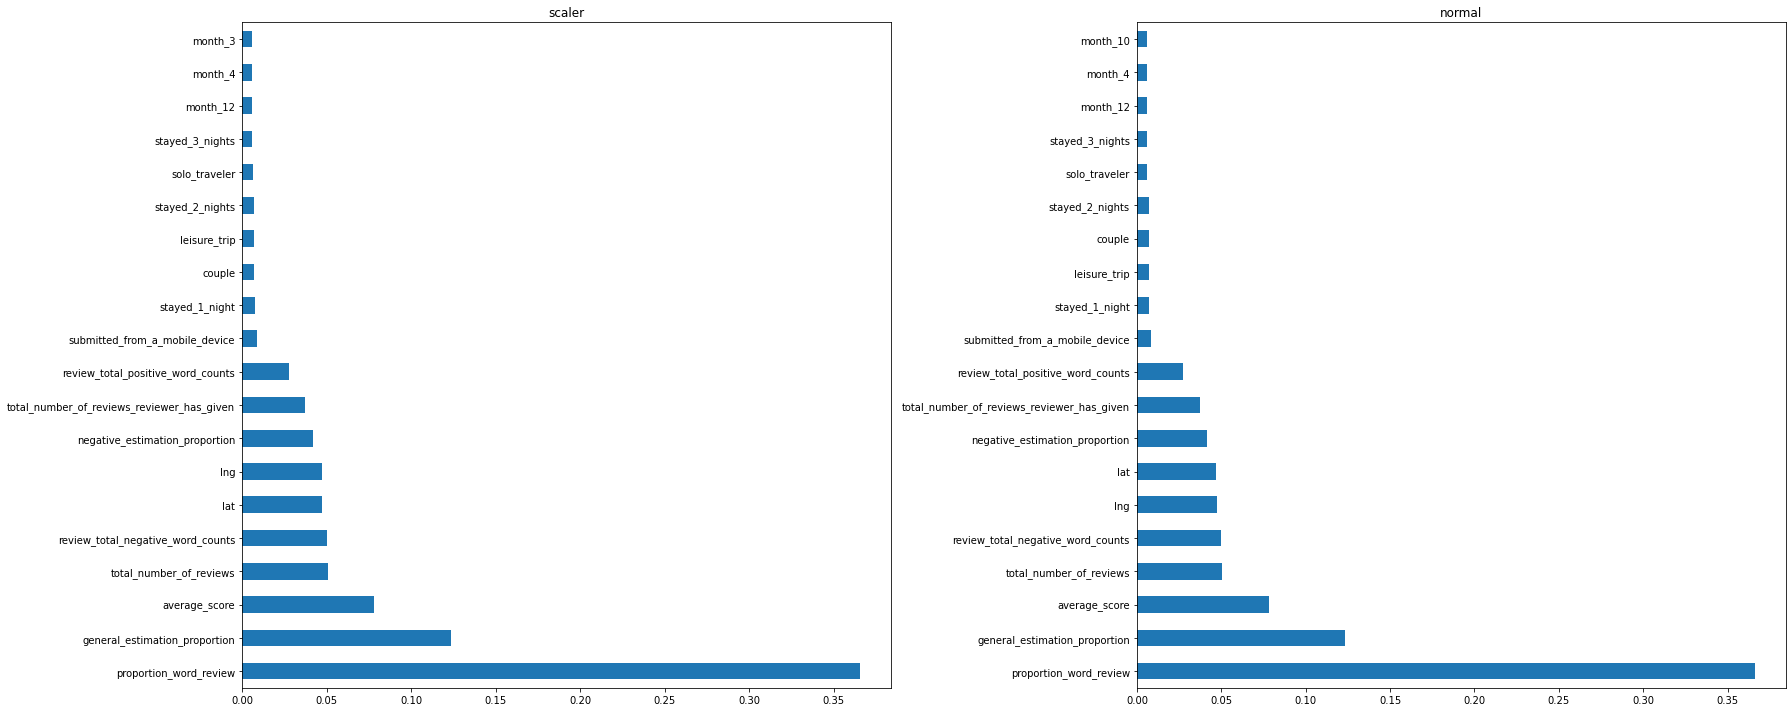

In [38]:
#топ 20 наиболее важных признаков для модели
plt.rcParams['figure.figsize'] = (25,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances_scaler = pd.Series(regr_scaler.feature_importances_, index=X.columns)

plt.subplot(1, 2, 2)
feat_importances.nlargest(20).plot(kind='barh').set_title('normal')
plt.subplot(1, 2, 1)
feat_importances_scaler.nlargest(20).plot(kind='barh').set_title('scaler')
plt.tight_layout();

In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12654582635413295


In [39]:
print('MAPE normal:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('MAPE scaler:', metrics.mean_absolute_percentage_error(y_test_scaler, y_pred_scaler))

MAPE normal: 0.12814269849052978
MAPE scaler: 0.1282742892326329
